# Climatological Lagrangian Coherent Structure for Python

<div class="warning" style='padding:0.1em; background-color:#FFFFFF; color:#000000; border-left: solid #000000 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:rigth; margin-left:1em'>
<b>Objective: </b> Having climatological fields calculate the cLCSs for a region. </p>
<p style='margin-left:1em;'>
Climatological LCS based on the code developed by Rodrigo Duran for Matlab (https://bitbucket.org/rodu/clcss/src/master/)
</p>
<p style='margin-left:1em;'>
This code replicates the results as seen on Montano Orozco, M. M. (2023).
<p style='margin-left:1em;'>
Dec - 2023 | Mireya M. Montano | mireya.mmor@gmail.com
</p>
<p style='margin-bottom:1em; margin-right:1em; text-align:right; font-family:Georgia'>
</p></span>
</div>


Montano Orozco, M. M. (2023). Hydrodynamics and coastal dispersion from the Bay of Plenty, Aotearoa, New Zealand: A 25-year numerical modelling perspective (Thesis, Doctor of Philosophy). University of Otago. Retrieved from http://hdl.handle.net/10523/16243. 

[For a better formatted version of the thesis (working embedded links) please click here](https://drive.google.com/file/d/1WMgq2lu7K5MjGTy6O5YpoKDkONDclkHo/view?usp=sharing)

## Extracting Data

As part of the Moana Project the data for the Bay of Plenty (region of study) is available through [THREDDS](http://thredds.moanaproject.org:6443/thredds/catalog/moana/catalog.html) server. Therefore, we can just call the desired file providing the link.

In [1]:
import os

THREDDS_SERVER = "http://thredds.moanaproject.org:6443/thredds/dodsC/moana/"
BOP_CLIMA_PATH = f"BoP_1km/climatology_sigma/BoP_climatology_"

PATH = os.path.join(THREDDS_SERVER, BOP_CLIMA_PATH)

### Parameters needed
#### File/environment related parameters
In this section we define the file-environment related parameters. Such as:
- month: month to analyse
- climatology_file: path to the climatology file with the velocity fields
- dirr: Working directory where the generated files are going to be saved. In this case we are using the current directory as an example
- vars_dict: Dictionary containing the names associated to the lon, lat and mask variables within the file. ROMS example:
  - {"mask": "mask_rho", "lon": "lon_rho", "lat": "lat_rho"}
- domain: choosing a zoom-in domain allows to see a better representation of the coastal or higher resolution dynamics. Provide box limits [lonmin, lonmax, latmin, latmax]

In [2]:
month = 1
m = "%02d" % int(month)
climatology_file = f"{PATH}{m}.nc"
dirr = os.getcwd()

vars_dict = {
    "mask": "mask_rho",
    "lon": "lon_rho",
    "lat": "lat_rho",
    "lon_dim": "xi_rho",
    "lat_dim": "eta_rho",
}
# lonmin, lonmax, latmin, latmax indices
domain = [175.700, 178.315, -38.060, -37.05369]

xarray example of data

In [3]:
import xarray as xr

ds = xr.open_dataset(climatology_file)

ds

/Users/mireyamontano/miniforge3/envs/cLCS/lib/python3.11/site-packages/xarray/coding/times.py:167: SerializationWarning: Ambiguous reference date string: 1-1-1 0:0:0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 0:0:0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


<xarray.Dataset>
Dimensions:      (tracer: 2, s_rho: 50, s_w: 51, eta_rho: 315, xi_rho: 400,
                  ocean_time: 31)
Coordinates:
  * s_rho        (s_rho) float64 -0.9849 -0.9552 -0.9258 ... -0.01515 -0.004949
  * s_w          (s_w) float64 -1.0 -0.97 -0.9404 -0.9112 ... -0.02041 -0.01 0.0
    lon_rho      (eta_rho, xi_rho) float64 ...
    lat_rho      (eta_rho, xi_rho) float64 ...
  * ocean_time   (ocean_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-...
Dimensions without coordinates: tracer, eta_rho, xi_rho
Data variables: (12/44)
    spherical    float64 ...
    Akt_bak      (tracer) float64 ...
    Akv_bak      float64 ...
    Akk_bak      float64 ...
    Akp_bak      float64 ...
    rdrg         float64 ...
    ...           ...
    u            (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    v            (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    w            (ocean_time, s_w, eta_rho, xi_rho) float64 ...
    ubar         (ocean_time, eta_rho, xi_rho) float64 ...
    vbar         (ocean_time, eta_rho, xi_rho) float64 ...
    zeta         (ocean_time, eta_rho, xi_rho) float64 ...
Attributes:
    file:           /nesi/nobackup/uoo02643/BoP_1km/BoP_climatology2_01.nc
    format:         netCDF-4 64bit offset file
    Conventions:    CF-1.4, SGRID=0.3
    type:           ROMS 27y Climatology
    title:          BoP 27y Climatology
    Description:    ROMS 27y Climatology from the BoP Climatology files V2 mo...
    Author:         Mireya Montano
    Created:        2023-01-31 15:27:15
    history:        Created by Climatology.py on 2023-01-31 15:27:15
    _NCProperties:  version=2,netcdf=4.8.1,hdf5=1.12.1

#### Particle release and OpenDrift configuration parameters

In this portion we define the particle release and Opendrfit configuration related parameters. 

Particle release:
- dx (int): Spacing between particles on the x-axis in km. Default: None = grid structure (1 particle per grid point)
- dy (int): Spacing between particles on the y-axis in km. Default None = grid structure (1 particle per grid point)
- T (int): Timescale to use, use negative timescale if a backward in time simulation is needed
- dt (int): Particle release time step in hours. Default 6 
- frequency_of_deployments (int): how often are particle releases made in days. Default 1
- time_step_output (int): If the output of the trajectories is required this will define the output time step in days. Default 1
- z (int): Depth of releases. The cLCS are calculated on the surface therefore the value is 0 however this analyses can be potentially done at different depths. 

For climatological LCS the user should use as much releases through the month as possible. However this code should be useful to estimate non-climatological LCSs if a release interval is provided and the or the daily_CG tensor values are stored. For this we added the following option. 
- start_releases (pd.datetime): User can define at what point in time releases should start. If Default - None releases are going to be released in every possible day according to the timescale (T) and the frequency of deployments
- end_releases (pd.datetime): User can define at what point in time releases should end. If Default- None releases are going to be released in every possible day according to the timescale (T) and the frequency of deployments

In [4]:
T = -7  # days
dx = 1  # km
dy = 1  # km
dt = 6  # hours
time_step_output = 86400  # seconds
frequency_of_deployments = 1  # days
z = 0  # meters



OpenDrift configuration:
- opendrift_reader (str): Reader for the files, see OpenDrift for more information. In this example we use "reader_ROMS_native_MOANA"
- opendrift_model (str): OpenDrift module to use. In this example we use "OceanDrift"
- log_level (int): Logging information for Opendrfit. 50 - No information, 20 For a certain amount, 0 for all the debugging
- max_speed (int): maximum speed particles are allowed to reach in m/s. Default 5
- horizontal_diffusivity (int): Particle release horizontal diffusivity. Default: 0.1
- advection_scheme (str): advection scheme of the particle release. Default: "runge-kutta4"

In [5]:
opendrift_reader = "reader_ROMS_native_MOANA"
opendrift_model = "OceanDrift"
log_level = 50  # 50 For no logging information, 20 For a certain amount, 0 for all the debugging
max_speed = 5
horizontal_diffusivity = 0.1
advection_scheme = "runge-kutta4"

#### OpenDrift releases and calculation of the Cauchy-Green Tensors.

This class returns a file containing the accumulated values associated with the calculation of the Cauchy-Green Tensors for each run of the chosen month. It can also return a file containing the calculated particle trajectories and the daily Cauchy-Green Tensor estimates,     save_trajectories=True and save_daily_CG=True respectively. 

<div class="warning" style='padding:0.1em; background-color:#FFFFFF; color:#69337A; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:rigth; margin-left:1em'>
<b>Note</b></p>
<p style='margin-left:1em;'>
The duration of the run depends on the size of the grid. For example, for a 315x400 grid. Each release takes about a minute (~115.5K particles per release, 22 to 24 releases per month). Therefore the calculation for each month varies between 25 to 30 minutes. For a 229x113, this process takes 5 minutes. However once it is run and the TOT-%m.p pickle file is saved there is no need to re-run the particle simulation.  
</p>
<p style='margin-bottom:1em; margin-right:1em; text-align:right; font-family:Georgia'>
</p></span>
</div>


In [6]:
from cLCS.mean_C import mean_CG

CG = mean_CG(
    dirr,
    climatology_file,
    month,
    domain,
    dx,
    dy,
    T,
    dt,
    frequency_of_deployments,
    time_step_output,
    z,
    opendrift_reader,
    opendrift_model,
    log_level,
    vars_dict,
    max_speed,
    horizontal_diffusivity,
    advection_scheme,
    save_trajectories=False,
    save_daily_CG=True,
    start_releases=None,
    end_releases=None,
)

CG.run()

INFO:root:--- Creating output directory


/Users/mireyamontano/miniforge3/envs/cLCS/lib/python3.11/site-packages/xarray/coding/times.py:167: SerializationWarning: Ambiguous reference date string: 1-1-1 0:0:0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 0:0:0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
INFO:opendrift.readers.reader_ROMS_native:Opening dataset: http://thredds.moanaproject.org:6443/thredds/dodsC/moana/BoP_1km/climatology_sigma/BoP_climatology_01.nc
INFO:opendrift.readers.reader_ROMS_native:Opening file with Dataset
  warnings.warn(warning_msg, SerializationWarning)

INFO:opendrift.readers.reader_ROMS_native:Read GLS parameters from file.
INFO:opendrift.readers.basereader.structured:Making interpolator for lon,lat to x,y conversion...
INFO:root:--- 2020-01-08 12:00:00 Release


--- 2020-01-08 12:00:00 Release 1/24
--- Obtaining the final position of particles
--- Calculating Cauchy-Green Tensor
--- 2020-01-09 12:00:00 Release 2/24
--- Obtaining the final position of particles
--- Calculating Cauchy-Green Tensor
--- 2020-01-10 12:00:00 Release 3/24
--- Obtaining the final position of particles
--- Calculating Cauchy-Green Tensor
--- 2020-01-11 12:00:00 Release 4/24
--- Obtaining the final position of particles
--- Calculating Cauchy-Green Tensor
--- 2020-01-12 12:00:00 Release 5/24
--- Obtaining the final position of particles
--- Calculating Cauchy-Green Tensor
--- 2020-01-13 12:00:00 Release 6/24
--- Obtaining the final position of particles
--- Calculating Cauchy-Green Tensor
--- 2020-01-14 12:00:00 Release 7/24
--- Obtaining the final position of particles
--- Calculating Cauchy-Green Tensor
--- 2020-01-15 12:00:00 Release 8/24
--- Obtaining the final position of particles
--- Calculating Cauchy-Green Tensor
--- 2020-01-16 12:00:00 Release 9/24
--- Obtaini

#### Squeezelines computation
Using the Cauchy-green calculations this portion of the code computes the squeezelines which are a function of (X,Y)

This code integrates line field from 0 to arclength.

Suggestion: arclength = 150

The output of this class is a file cLCS_%m.p containing the squeezelines (X,Y). Once this file is created there is no need to repeat the process to visualise the cLCSs

In [6]:
from cLCS.make_cLCS import compute_cLCS_squeezelines

squeezelines = compute_cLCS_squeezelines(
    f"{dirr}/", month, arclength=150, climatology=True
)

squeezelines.run()

/Users/mireyamontano/Documents/PhD/cLCS/cLCS/make_cLCS.py:83: RuntimeWarning: All-NaN slice encountered
  lda2bIb = np.nanmax(lda2b.ravel())



<div class="warning" style='padding:0.1em; background-color:#FFFFFF; color:#E49B0F; border-left: solid #FDDA0D 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:rigth; margin-left:1em'>
<b>Note</b></p>
<p style='margin-left:1em;'>
If not interested in the climatological aspect aka the averaging define climatology=False to obtain the squeezelines for each Cauchy-Green Tensor available in the folder.
</p></span>
</div>

In [7]:
from cLCS.make_cLCS import compute_cLCS_squeezelines

squeezelines = compute_cLCS_squeezelines(
    f"{dirr}/", month, arclength=150, climatology=False
)

squeezelines.run()

/Users/mireyamontano/Documents/PhD/cLCS/cLCS/make_cLCS.py:83: RuntimeWarning: All-NaN slice encountered
  lda2bIb = np.nanmax(lda2b.ravel())


In [8]:
import numpy as np

PX, PY = np.load(f"{dirr}/{m}/cLCS_01.p", "rb", allow_pickle=True)

print(f"This dataset has {PX.shape[0]} squeezelines with {PX.shape[1]} segments each")

This dataset has 419 squeezelines with 150 segments each


#### Visualisation of cLCSs

This section plots the coloured lines of cLCSs returns the fig and ax object. 

Again the working directory and the month being analysed has to be provided. 

Other parameters that can be defined are:
- colourmap (str): Colourmap must be provided, you can chose from one of the options provided on the [README file](https://github.com/MireyaMMO/cLCS/blob/main/README.md#additional-info), or just use a pyplot colormap string.
- lw (int): linewidth. Default 0.8
- fig and/or ax (object): in case the plan is to make a subplot these figures if not a new figure and ax will be created. 
- projection: cartopy associated projection 
- line_spacing (int): to plot every other line (Default: 4)
- save_fig (str): If you want to save the generated figure define the format in which you need the figure (i.e., pdf,svg,png). Default: None 
- corners: if not defined, the script will identify the corners of the domain. [lonmin, lonmax, latmin, latmax]

<!-- <div class="warning" style='padding:0.1em; background-color:#FFFFFF; color:#F28C28; border-left: solid #C04000 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:rigth; margin-left:1em'>
<b>Note</b></p>
<p style='margin-left:1em;'>
It is a slow code as it segments each portion of the line to identify the intensity of the LCS in that segment. This is a process that is applied to each line as well. This example has 590 squeezelines with 150 segments each line.  
</p>
<p style='margin-left:1em;'>
This can probably be improved.
</p>
<p style='margin-bottom:1em; margin-right:1em; text-align:right; font-family:Georgia'>
</p></span>
</div> -->


---- Generating figure with cartopy features
---- High-resolution Cartopy features added
---- Squeezeline and associated data loaded
---- Saving Figure
---- Done


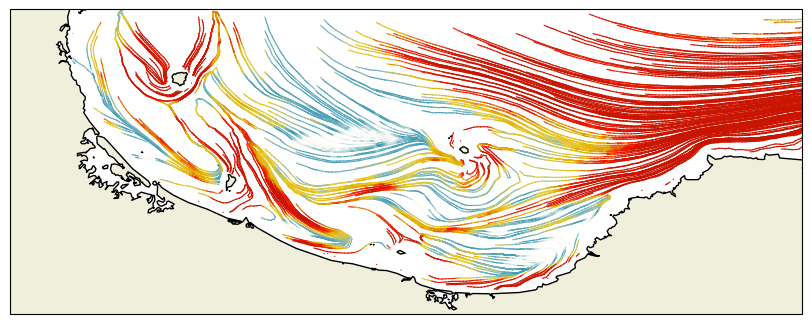

In [6]:
from cLCS.plotting_cLCS import *

fig, ax = cLCSrho_cartopy_colour(
    dirr,
    month,
    colourmap="Zissou",
    fig=None,
    ax=None,
    projection=ccrs.PlateCarree(),
    line_spacing=1,
    save_fig="png",
    corners=[175.7, 178.29, -38.0591, -37.0626],
    climatology=True,
)

If only a quick visualisation is needed or the intensity of the cLCS is not relevant there is a faster monochrome option available.

Parameters:
- dirr (str): directory where all the outputs are being saved
- month (int): month that is being analysed 
- fig, ax (object)
- color (str): color requested. Default: 'black'
- alpha (int): as in matplotlib if transparency is needed. Default: 1
- lw (int): linewidth. Default: 0.8
- projection: cartopy associated projection
- line_spacing (int): to make process faster just plot every other line. Default: 1
- save_fig (str): If you want to save the generated figure define the format in which you need the figure (i.e., pdf,svg,png). Default: None (no figure saved). 
- corners: if not defined, the script will identify the corners of the domain. [lonmin, lonmax, latmin, latmax]

---- Generating figure with cartopy features
---- High-resolution Cartopy features added
---- Saving Figure
---- Done


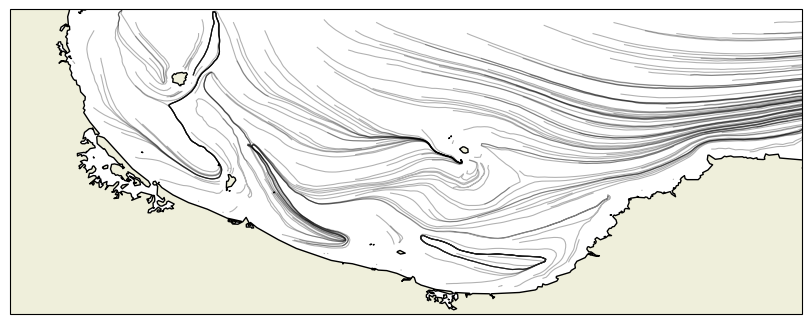

In [10]:
from cLCS.plotting_cLCS import *

fig_mono, ax_mono = cLCSrho_cartopy_monochrome(
    dirr,
    month,
    fig=None,
    ax=None,
    color="k",
    alpha=0.3,
    lw=0.8,
    line_spacing=2,
    projection=ccrs.PlateCarree(central_longitude=180),
    save_fig="png",
    corners=[175.7, 178.29, -38.0591, -37.0626],
)

<div class="warning" style='padding:0.1em; background-color:#FFFFFF; color:#E37383; border-left: solid #9F2B68 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:rigth; margin-left:1em'>
<b>Note</b></p>
<p style='margin-left:1em;'>
To plot non-climatological LCS define climatology=False and provide the files containing the Cauchy Green Tensor and the squeezelines, as seen in example below
</p></span>
</div>

---- Generating figure with cartopy features
---- High-resolution Cartopy features added
---- Squeezeline and associated data loaded
---- Saving Figure
---- Done


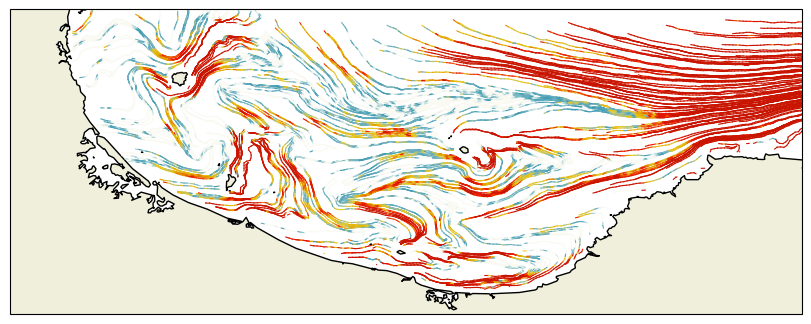

In [7]:
from cLCS.plotting_cLCS import *

fig, ax = cLCSrho_cartopy_colour(
    dirr,
    month,
    colourmap="Zissou",
    fig=None,
    ax=None,
    projection=ccrs.PlateCarree(),
    line_spacing=1,
    save_fig="png",
    corners=[175.7, 178.29, -38.0591, -37.0626],
    climatology=False,
    squeezelines_file=f"{dirr}/{m}/LCS_0108.p",
    CG_file=f"{dirr}/{m}/LCS_0108-CG.p",
)

### Additional notes
<div class="warning" style='padding:0.1em; background-color:#FFFFFF; color:#009E60; border-left: solid #097969 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:rigth; margin-left:1em'>
<b>Note</b></p>
<p style='margin-left:1em;'>
It is important to remark that each study region and application of cLCS is different and question-dependant so tests with different parameters are recommended to assess the best configuration. For this study we had a 27-year hindcast of a coastal region and we were interested in looking into the persistent patterns on the coastal region. 
</p>
<p style='margin-left:1em;'>
Other cLCSs studies:
</p>
<p style='margin-left:1em;'>

- Duran, R., Beron-Vera, F.J. & Olascoaga, M.J. Extracting quasi-steady Lagrangian transport patterns from the ocean circulation: An application to the Gulf of Mexico. Sci Rep 8, 5218 (2018). https://doi.org/10.1038/s41598-018-23121-y 
- Gough, M. K., Beron-Vera, F. J., Olascoaga, M. J., Sheinbaum, J., Jouanno, J., and Duran, R. (2019). Persistent Lagrangian Transport Patterns in the Northwestern Gulf of Mexico. Journal of Physical Oceanography, 49 (2), 353–367. https://doi.org/10.1175/JPO-D-17-0207.1 
- Gouveia, M.B., Duran, R., Lorenzzetti, J.A. et al. Persistent meanders and eddies lead to quasi-steady Lagrangian transport patterns in a weak western boundary current. Sci Rep 11, 497 (2021). https://doi.org/10.1038/s41598-020-79386-9 
- Maslo, A., Azevedo Correia de Souza, J. M., Andrade-Canto, F., and Rodríguez Outerelo, J. (2020). Connectivity of deep waters in the Gulf of Mexico. Journal of Marine Systems, 203, 103267. https://doi.org/10.1016/j.jmarsys.2019.103267 
</p>
<p style='margin-bottom:1em; margin-right:1em; text-align:right; font-family:Georgia'>
</p></span>
</div>
